# AE-TSCM + VQVAE v6 — Mayor capacidad + Codebook estable

Pipeline de fusión multi-iluminación para detección de defectos superficiales.

**Pipeline:** 5 luces (SUP_IZQ, SUP_DER, INF_DER, INF_IZQ, ALL) → AE-TSCM → RGB → VQVAE → 5 luces reconstruidas

**Cambios vs v5:**
- ✅ **SIN CosineAnnealingLR** — learning rate constante 1e-3
- ✅ **Mayor capacidad** — `hidden_channels=128`, `num_residual=4` (~8.5M params vs 2.1M)
- ✅ **Codebook EMA** — actualización por media móvil exponencial (sin gradientes), más estable
- ✅ **Codebook reset** — reemplaza entradas no usadas cada N épocas, evita codebook collapse
- ✅ **Codebook más pequeño** — 256 entradas (vs 512), más fácil de utilizar completamente
- ✅ **Optimizaciones de memoria** — `pin_memory=False`, `num_workers` reducidos, limpieza de caché CUDA
- Resolución completa sin resize (5472×3072)
- Encoder/Decoder con 4 etapas de downsampling (16x)
- Mixed precision (AMP) + gradient accumulation
- Requiere A100 (40GB+)

---

## 1. Setup

In [ ]:
!pip install pytorch-msssim -q

In [28]:
import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
# NO importamos scheduler — el paper usa LR constante
from torch.amp import autocast, GradScaler
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
from pytorch_msssim import ssim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    

Dispositivo: cuda
GPU: NVIDIA A40


## 2. Montar Google Drive y configurar rutas

Sube la carpeta `MT001/` a tu Google Drive, por ejemplo en `MyDrive/dataset/MT001/`.

In [29]:


# ============================================================
# AJUSTA ESTA RUTA a donde subiste la carpeta MT001
# ============================================================
DATASET_DIR = 'dataset/dataset/MT001'



## 3. Configuración

In [49]:
CONFIG = {
    # Datos
    'data_dir': DATASET_DIR,
    'num_lights': 5,              # SUP_IZQ, SUP_DER, INF_DER, INF_IZQ, ALL
    'batch_size': 1,              # Batch size 1 para resolución completa
    'gradient_accumulation_steps': 4,  # Simula batch efectivo de 4

    # Modelo AE-TSCM
    'use_spatial_attention': True,

    # Modelo VQVAE — mayor capacidad para A100
    'hidden_channels': 128,       # 128 vs 64 en v5 → más capacidad en encoder/decoder
    'num_residual': 4,            # 4 bloques residuales vs 2 en v5
    'num_embeddings': 128,        # 256 vs 512 → codebook más pequeño, más fácil de utilizar
    'embedding_dim': 128,         # 128 vs 64 → latent más expresivo

    # Codebook EMA
    'ema_decay': 0.99,            # Factor de decaimiento para EMA
    'commitment_cost': 0.25,      # Peso del commitment loss
    'codebook_reset_interval': 10,  # Reset entradas no usadas cada N épocas
    'codebook_usage_threshold': 1,  # Mínimo de usos para no ser reseteada

    # Entrenamiento
    'epochs': 150,
    'learning_rate': 1e-3,        # LR constante, sin scheduler
    'weight_decay': 1e-5,

    # Pesos de pérdidas
    'lambda_mse': 1.0,
    'lambda_ssim': 0.05,
    'lambda_vq': 0.02,

    # Guardado
    'save_interval': 25,
    'log_interval': 10,
}

# Directorio de salida en Drive para no perder resultados
SAVE_DIR = 'runs/ae_tscm_v6_' + datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'visualizations'), exist_ok=True)
print(f'Resultados se guardarán en: {SAVE_DIR}')

Resultados se guardarán en: runs/ae_tscm_v6_20260127_144946


## 4. Dataset — Loader para formato MT001

In [50]:
# Orden fijo de las luces
LIGHT_NAMES = ['SUP_IZQ', 'SUP_DER', 'INF_DER', 'INF_IZQ', 'ALL']


class CropToDivisible:
    """Recorta la imagen para que H y W sean divisibles por un factor (16 para 4 etapas de stride 2)."""
    def __init__(self, factor=16):
        self.factor = factor

    def __call__(self, img):
        _, h, w = img.shape
        new_h = (h // self.factor) * self.factor
        new_w = (w // self.factor) * self.factor
        top = (h - new_h) // 2
        left = (w - new_w) // 2
        return img[:, top:top + new_h, left:left + new_w]


class MT001Dataset(Dataset):
    """
    Dataset para imágenes MT001 con 5 iluminaciones.
    Agrupa por num_captura y devuelve (5, H, W) en escala de grises.
    Trabaja a resolución completa (sin resize).
    """

    def __init__(self, root_dir, light_names=LIGHT_NAMES, transform=None, captures=None):
        self.root_dir = root_dir
        self.light_names = light_names
        self.num_lights = len(light_names)
        self.transform = transform
        self.groups = self._parse_metadata(captures)
        print(f'  Dataset: {len(self.groups)} capturas, {self.num_lights} luces cada una')

    def _parse_metadata(self, captures):
        metadata_path = os.path.join(self.root_dir, 'metadata.csv')
        groups = defaultdict(dict)

        with open(metadata_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                cap = int(row['num_captura'])
                luz = row['luz']
                if luz in self.light_names:
                    groups[cap][luz] = row['imagen']

        valid = []
        for cap in sorted(groups.keys()):
            if captures is not None and cap not in captures:
                continue
            if len(groups[cap]) == self.num_lights:
                valid.append((cap, groups[cap]))

        return valid

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        cap_num, filenames = self.groups[idx]
        channels = []

        for light_name in self.light_names:
            img_path = os.path.join(self.root_dir, filenames[light_name])
            image = Image.open(img_path).convert('L')  # Escala de grises
            image = transforms.ToTensor()(image)  # (1, H, W), rango [0,1]
            channels.append(image)

        multi_channel = torch.cat(channels, dim=0)  # (5, H, W)

        if self.transform:
            multi_channel = self.transform(multi_channel)

        return multi_channel


def get_train_transforms():
    """Transforms para entrenamiento a resolución completa."""
    return transforms.Compose([
        CropToDivisible(16),
        transforms.RandomHorizontalFlip(p=0.5),
    ])


def get_val_transforms():
    """Transforms para validación a resolución completa."""
    return transforms.Compose([
        CropToDivisible(16),
    ])

In [51]:
# Crear dataset con TODAS las capturas (sin split, como el paper)
train_dataset = MT001Dataset(
    CONFIG['data_dir'],
    transform=get_train_transforms(),
)

# OPTIMIZACIÓN: pin_memory=False para evitar OOM, num_workers reducido
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0,         # Reducido a 0 para minimizar uso de memoria
    pin_memory=False,      # Desactivado para evitar OOM en GPU
    persistent_workers=False
)

# Verificar una muestra
sample = train_dataset[0]
print(f'\nForma muestra: {sample.shape}')  # (5, H, W) a resolución completa
print(f'Rango valores: [{sample.min():.3f}, {sample.max():.3f}]')
print(f'Total capturas para entrenamiento: {len(train_dataset)}')

# Verificar memoria disponible
if torch.cuda.is_available():
    print(f'\nMemoria GPU:')
    print(f'  Asignada: {torch.cuda.memory_allocated(0)/1e9:.2f} GB')
    print(f'  Reservada: {torch.cuda.memory_reserved(0)/1e9:.2f} GB')
    print(f'  Disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0))/1e9:.2f} GB')

  Dataset: 62 capturas, 5 luces cada una

Forma muestra: torch.Size([5, 3072, 5472])
Rango valores: [0.000, 1.000]
Total capturas para entrenamiento: 62

Memoria GPU:
  Asignada: 2.37 GB
  Reservada: 16.96 GB
  Disponible: 49.16 GB


## 5. Modelos

In [52]:
# ============================================================
# AE-TSCM: Attention-Enhanced Taylor Series Channel Mixer
# ============================================================

class ChannelAttention(nn.Module):
    """SE-Net: aprende qué luces son más importantes."""
    def __init__(self, num_channels, reduction=2):
        super().__init__()
        hidden = max(num_channels // reduction, 4)
        self.attention = nn.Sequential(
            nn.Linear(num_channels, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        gap = x.mean(dim=[2, 3])
        weights = self.attention(gap)
        return weights.view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    """CBAM: aprende qué regiones espaciales son más importantes."""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = x.mean(dim=1, keepdim=True)
        max_out, _ = x.max(dim=1, keepdim=True)
        return self.conv(torch.cat([avg_out, max_out], dim=1))


class TaylorTransform(nn.Module):
    """Transformación no lineal de intensidad con coeficientes aprendibles."""
    def __init__(self, num_coefficients=5):
        super().__init__()
        initial = torch.zeros(num_coefficients)
        initial[1] = 1.0  # f(x) = x inicialmente
        self.coefficients = nn.Parameter(initial)

    def forward(self, x):
        c = self.coefficients
        return (c[0] + c[1]*x + c[2]*(x**2)/2 + c[3]*(x**3)/6 + c[4]*(x**4)/24)


class ChannelMixer(nn.Module):
    """Mezcla N canales a M canales con conv 1x1."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mixer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.mixer(x)


class ChannelNormalize(nn.Module):
    """Normaliza cada canal a [0, 1]."""
    def forward(self, x):
        b, c, h, w = x.shape
        x_flat = x.view(b, c, -1)
        mn = x_flat.min(dim=2, keepdim=True)[0].unsqueeze(-1)
        mx = x_flat.max(dim=2, keepdim=True)[0].unsqueeze(-1)
        return (x - mn) / (mx - mn + 1e-8)


class AE_TSCM(nn.Module):
    """5 luces → 3 canales RGB."""
    def __init__(self, in_channels=5, out_channels=3, use_spatial_attention=True):
        super().__init__()
        self.use_spatial_attention = use_spatial_attention
        self.taylor = TaylorTransform(5)
        self.channel_attention = ChannelAttention(in_channels)
        if use_spatial_attention:
            self.spatial_attention = SpatialAttention(7)
        self.mixer = ChannelMixer(in_channels, out_channels)
        self.normalize = ChannelNormalize()

    def forward(self, x, return_attention=False):
        x = self.taylor(x)
        ch_w = self.channel_attention(x)
        x = x * ch_w
        sp_w = None
        if self.use_spatial_attention:
            sp_w = self.spatial_attention(x)
            x = x * sp_w
        x = self.mixer(x)
        x = self.normalize(x)
        if return_attention:
            return x, ch_w.squeeze(), sp_w
        return x

In [53]:
# ============================================================
# VQVAE: Vector Quantized VAE — 4 etapas (16x down/up)
# Con EMA codebook + reset de entradas no usadas
# ============================================================

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


class Encoder(nn.Module):
    """4 etapas de downsampling (16x) para resolución completa."""
    def __init__(self, in_channels=3, hidden_channels=128, embedding_dim=128, num_residual=4):
        super().__init__()
        hc = hidden_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, hc, 4, stride=2, padding=1), nn.ReLU())       # /2
        self.conv2 = nn.Sequential(
            nn.Conv2d(hc, hc, 4, stride=2, padding=1), nn.ReLU())                # /4
        self.conv3 = nn.Sequential(
            nn.Conv2d(hc, hc * 2, 4, stride=2, padding=1), nn.ReLU())            # /8
        self.conv4 = nn.Sequential(
            nn.Conv2d(hc * 2, hc * 2, 4, stride=2, padding=1), nn.ReLU())        # /16
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(hc * 2) for _ in range(num_residual)])
        self.to_latent = nn.Conv2d(hc * 2, embedding_dim, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.residual_blocks(x)
        return self.to_latent(x)


class VectorQuantizerEMA(nn.Module):
    """
    VQ con actualización EMA del codebook (más estable que gradientes).
    Incluye reset de entradas no usadas para evitar codebook collapse.
    """
    def __init__(self, num_embeddings=256, embedding_dim=128,
                 commitment_cost=0.25, decay=0.99, epsilon=1e-5):
        super().__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        # Codebook — inicialización uniforme
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        self.codebook.weight.requires_grad = False  # EMA actualiza, no gradientes

        # Buffers EMA (no son parámetros del optimizador)
        self.register_buffer('ema_cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('ema_dw', self.codebook.weight.data.clone())
        self.register_buffer('usage_count', torch.zeros(num_embeddings))

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_shape = z.shape
        z_flat = z.view(-1, self.embedding_dim)

        # Distancias al codebook
        distances = (
            torch.sum(z_flat**2, dim=1, keepdim=True) +
            torch.sum(self.codebook.weight**2, dim=1) -
            2 * torch.matmul(z_flat, self.codebook.weight.t())
        )

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).float()
        quantized = self.codebook(encoding_indices).view(z_shape)

        # EMA update del codebook (solo en training)
        if self.training:
            encodings_sum = encodings.sum(0)
            dw = encodings.t() @ z_flat

            self.ema_cluster_size.data.mul_(self.decay).add_(
                encodings_sum, alpha=1 - self.decay)
            self.ema_dw.data.mul_(self.decay).add_(
                dw, alpha=1 - self.decay)

            # Laplace smoothing para evitar divisiones por cero
            n = self.ema_cluster_size.sum()
            cluster_size = (
                (self.ema_cluster_size + self.epsilon) /
                (n + self.num_embeddings * self.epsilon) * n
            )

            self.codebook.weight.data.copy_(
                self.ema_dw / cluster_size.unsqueeze(1))

            # Acumular uso para reset
            self.usage_count.add_(encodings_sum)

        # Solo commitment loss (codebook se actualiza por EMA, no por gradientes)
        commitment_loss = F.mse_loss(z, quantized.detach())
        loss = self.commitment_cost * commitment_loss

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        # Perplexity (mide utilización del codebook)
        avg_probs = encodings.mean(0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        return quantized, loss, perplexity

    def reset_unused_codes(self, z_flat_samples, threshold=2):
        """
        Reemplaza entradas del codebook con uso < threshold
        por vectores aleatorios del encoder (z_flat_samples).
        """
        unused_mask = self.usage_count < threshold
        num_unused = unused_mask.sum().item()

        if num_unused > 0 and z_flat_samples.shape[0] > 0:
            n_replace = min(int(num_unused), z_flat_samples.shape[0])
            # Muestrear vectores del encoder para reemplazar entradas muertas
            perm = torch.randperm(z_flat_samples.shape[0], device=z_flat_samples.device)
            replace_vectors = z_flat_samples[perm[:n_replace]].detach()

            unused_indices = torch.where(unused_mask)[0][:n_replace]
            self.codebook.weight.data[unused_indices] = replace_vectors
            self.ema_dw.data[unused_indices] = replace_vectors
            self.ema_cluster_size.data[unused_indices] = 1.0

        # Reset contador de uso para el siguiente periodo
        self.usage_count.zero_()
        return num_unused


class Decoder(nn.Module):
    """4 etapas de upsampling (16x) para resolución completa."""
    def __init__(self, out_channels=5, hidden_channels=128, embedding_dim=128, num_residual=4):
        super().__init__()
        hc = hidden_channels
        self.from_latent = nn.Conv2d(embedding_dim, hc * 2, 1)
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(hc * 2) for _ in range(num_residual)])
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(hc * 2, hc * 2, 4, stride=2, padding=1), nn.ReLU())   # x2
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(hc * 2, hc, 4, stride=2, padding=1), nn.ReLU())       # x4
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(hc, hc, 4, stride=2, padding=1), nn.ReLU())           # x8
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(hc, out_channels, 4, stride=2, padding=1), nn.Sigmoid())  # x16

    def forward(self, z):
        x = self.from_latent(z)
        x = self.residual_blocks(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return self.deconv4(x)


class VQVAE(nn.Module):
    def __init__(self, in_channels=3, out_channels=5, hidden_channels=128,
                 num_residual=4, num_embeddings=256, embedding_dim=128,
                 commitment_cost=0.25, ema_decay=0.99):
        super().__init__()
        self.encoder = Encoder(in_channels, hidden_channels, embedding_dim, num_residual)
        self.vq = VectorQuantizerEMA(num_embeddings, embedding_dim, commitment_cost, ema_decay)
        self.decoder = Decoder(out_channels, hidden_channels, embedding_dim, num_residual)

    def forward(self, x):
        z = self.encoder(x)
        z_q, vq_loss, perplexity = self.vq(z)
        return self.decoder(z_q), vq_loss, perplexity

    def encode(self, x):
        z = self.encoder(x)
        z_q, _, _ = self.vq(z)
        return z_q

In [54]:
# ============================================================
# Modelo Completo: AE-TSCM + VQVAE
# ============================================================

class FullModel(nn.Module):
    """5 luces → AE-TSCM → RGB → VQVAE → 5 luces reconstruidas"""

    def __init__(self, config):
        super().__init__()
        self.ae_tscm = AE_TSCM(
            in_channels=config['num_lights'],
            out_channels=3,
            use_spatial_attention=config['use_spatial_attention']
        )
        self.vqvae = VQVAE(
            in_channels=3,
            out_channels=config['num_lights'],
            hidden_channels=config['hidden_channels'],
            num_residual=config['num_residual'],
            num_embeddings=config['num_embeddings'],
            embedding_dim=config['embedding_dim'],
            commitment_cost=config['commitment_cost'],
            ema_decay=config['ema_decay']
        )

    def forward(self, x, return_intermediate=False):
        if return_intermediate:
            rgb, ch_att, sp_att = self.ae_tscm(x, return_attention=True)
        else:
            rgb = self.ae_tscm(x, return_attention=False)
        reconstructed, vq_loss, perplexity = self.vqvae(rgb)
        if return_intermediate:
            return reconstructed, vq_loss, perplexity, rgb, ch_att, sp_att
        return reconstructed, vq_loss, perplexity


# Crear modelo y mostrar parámetros
model = FullModel(CONFIG).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Parámetros totales: {total_params:,}')
print(f'Parámetros entrenables: {trainable_params:,}  (codebook se actualiza por EMA)')
print(f'Codebook: {CONFIG["num_embeddings"]} entradas × {CONFIG["embedding_dim"]}d')

# Verificar memoria después de crear modelo
if torch.cuda.is_available():
    print(f'\nMemoria GPU después de cargar modelo:')
    print(f'  Asignada: {torch.cuda.memory_allocated(0)/1e9:.2f} GB')
    print(f'  Reservada: {torch.cuda.memory_reserved(0)/1e9:.2f} GB')
    print(f'  Disponible: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0))/1e9:.2f} GB')

Parámetros totales: 13,211,446
Parámetros entrenables: 13,195,062  (codebook se actualiza por EMA)
Codebook: 128 entradas × 128d

Memoria GPU después de cargar modelo:
  Asignada: 2.42 GB
  Reservada: 16.96 GB
  Disponible: 49.11 GB


## 6. Funciones de pérdida y visualización

In [55]:
def compute_loss(original, reconstructed, vq_loss, config):
    mse_loss = F.mse_loss(reconstructed, original)
    ssim_loss = 1 - ssim(reconstructed, original, data_range=1.0, size_average=True)
    total = (config['lambda_mse'] * mse_loss +
             config['lambda_ssim'] * ssim_loss +
             config['lambda_vq'] * vq_loss)
    return total, {
        'total': total.item(),
        'mse': mse_loss.item(),
        'ssim': ssim_loss.item(),
        'vq': vq_loss.item()
    }


def save_visualization(original, reconstructed, rgb, epoch, save_dir):
    original = original[0].detach().cpu()
    reconstructed = reconstructed[0].detach().cpu()
    rgb = rgb[0].detach().cpu()
    num_lights = original.shape[0]

    fig, axes = plt.subplots(3, max(num_lights, 3), figsize=(3*num_lights, 9))

    for i in range(num_lights):
        axes[0, i].imshow(original[i], cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f'Orig {LIGHT_NAMES[i]}', fontsize=8)
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed[i], cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f'Recon {LIGHT_NAMES[i]}', fontsize=8)
        axes[1, i].axis('off')

    rgb_img = rgb.permute(1, 2, 0).numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min() + 1e-8)
    axes[2, 0].imshow(rgb_img)
    axes[2, 0].set_title('RGB Fusionado')
    axes[2, 0].axis('off')
    for i in range(1, max(num_lights, 3)):
        axes[2, i].axis('off')

    plt.suptitle(f'Época {epoch}', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'epoch_{epoch:04d}.png'), dpi=100)
    plt.show()
    plt.close()


def plot_losses(history, save_dir):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    epochs = range(1, len(history['total']) + 1)

    for ax, key, title in zip(
        axes.flat[:4],
        ['total', 'mse', 'ssim', 'vq'],
        ['Total Loss', 'MSE Loss', 'SSIM Loss', 'VQ Loss']
    ):
        ax.plot(epochs, history[key], label='train')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.legend()

    # Perplexity (utilización del codebook)
    ax_perp = axes[1, 1]
    ax_perp.plot(epochs, history['perplexity'], label='perplexity', color='green')
    ax_perp.axhline(y=CONFIG['num_embeddings'], color='r', linestyle='--', alpha=0.5,
                    label=f'max ({CONFIG["num_embeddings"]})')
    ax_perp.set_title('Codebook Perplexity')
    ax_perp.set_xlabel('Epoch')
    ax_perp.legend()

    # SSIM value (1 - ssim_loss)
    ax_ssim_val = axes[1, 2]
    ssim_values = [1 - s for s in history['ssim']]
    ax_ssim_val.plot(epochs, ssim_values, label='SSIM', color='purple')
    ax_ssim_val.set_title('SSIM (calidad reconstrucción)')
    ax_ssim_val.set_xlabel('Epoch')
    ax_ssim_val.set_ylim(0, 1)
    ax_ssim_val.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'loss_history.png'), dpi=150)
    plt.show()
    plt.close()

## 7. Entrenamiento

In [56]:
def run_epoch(model, dataloader, optimizer, config, scaler=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_losses = {'total': 0, 'mse': 0, 'ssim': 0, 'vq': 0}
    total_perplexity = 0
    num_batches = 0
    accum_steps = config.get('gradient_accumulation_steps', 1)
    use_amp = scaler is not None

    ctx = torch.no_grad() if not train else torch.enable_grad()
    with ctx:
        if train:
            optimizer.zero_grad()
        for i, batch in enumerate(tqdm(dataloader, desc='Train', leave=False)):
            batch = batch.to(device)

            with autocast('cuda', enabled=use_amp):
                reconstructed, vq_loss, perplexity = model(batch)
                loss, loss_dict = compute_loss(batch, reconstructed, vq_loss, config)
                if train:
                    loss = loss / accum_steps

            if train:
                if use_amp:
                    scaler.scale(loss).backward()
                    if (i + 1) % accum_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                else:
                    loss.backward()
                    if (i + 1) % accum_steps == 0:
                        optimizer.step()
                        optimizer.zero_grad()

            for k in total_losses:
                total_losses[k] += loss_dict[k]
            total_perplexity += perplexity.item()
            num_batches += 1

        # Flush gradientes restantes si no son divisibles por accum_steps
        if train and num_batches % accum_steps != 0:
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()

    for k in total_losses:
        total_losses[k] /= max(num_batches, 1)
    avg_perplexity = total_perplexity / max(num_batches, 1)
    return total_losses, avg_perplexity


def collect_encoder_outputs(model, dataloader, max_samples=8):
    """Recoge outputs del encoder para usar como reemplazos en codebook reset."""
    model.eval()
    z_samples = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= max_samples:
                break
            batch = batch.to(device)
            with autocast('cuda'):
                rgb = model.ae_tscm(batch)
                z = model.vqvae.encoder(rgb)
            # Flatten spatial dims: (B, D, H, W) → (B*H*W, D)
            z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, z.shape[1])
            z_samples.append(z_flat.float())
    if z_samples:
        return torch.cat(z_samples, dim=0)
    return torch.empty(0)

Iniciando entrenamiento: 150 épocas
Muestras: 62 (todas, sin split)
Batch size: 1 | Gradient accumulation: 4 (batch efectivo: 4)
Learning rate: 0.001 (CONSTANTE, sin scheduler)
Mixed precision (AMP): activado
Codebook: 128 entradas, EMA decay=0.99, reset cada 10 épocas
⚡ Optimización de memoria: pin_memory=False, num_workers=0


Ep   1/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


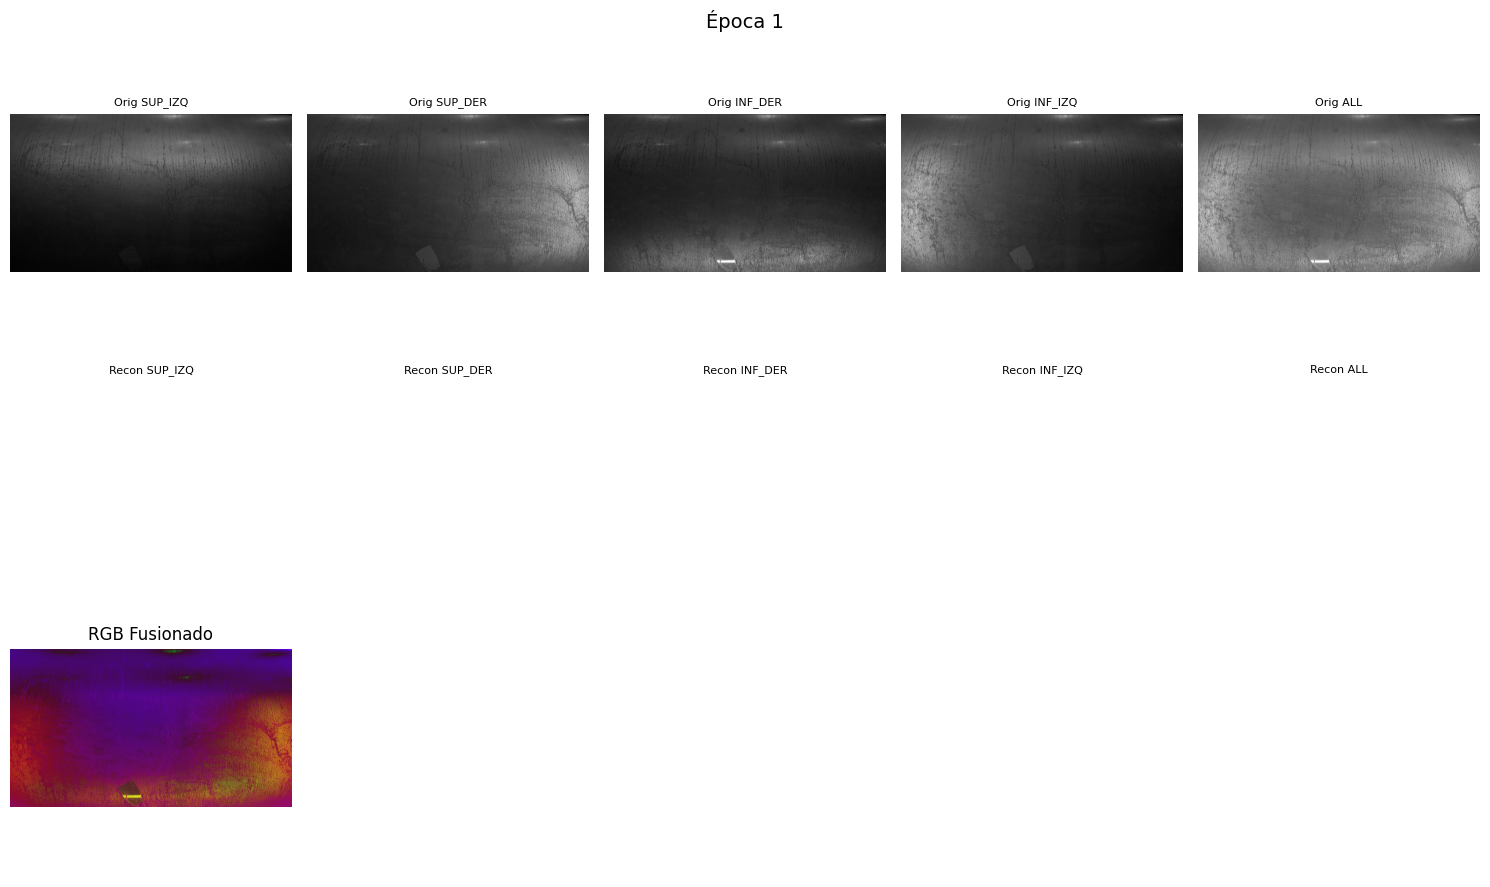

Ep   2/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   3/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   4/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   5/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   6/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   7/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   8/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep   9/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  10/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 2.86 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


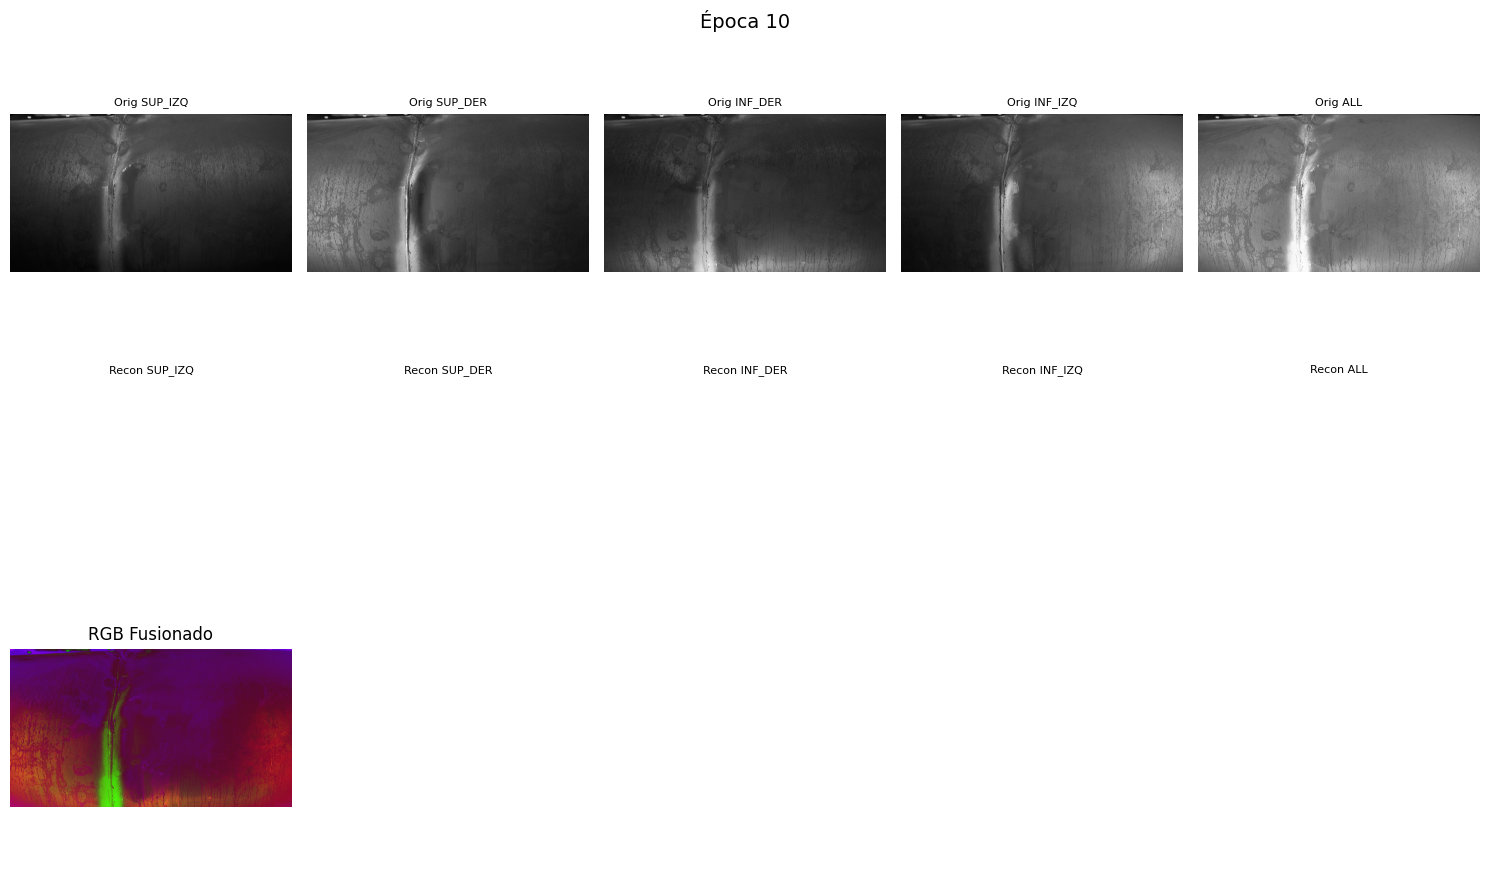

Ep  11/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  12/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  13/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  14/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  15/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  16/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  17/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  18/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  19/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  20/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


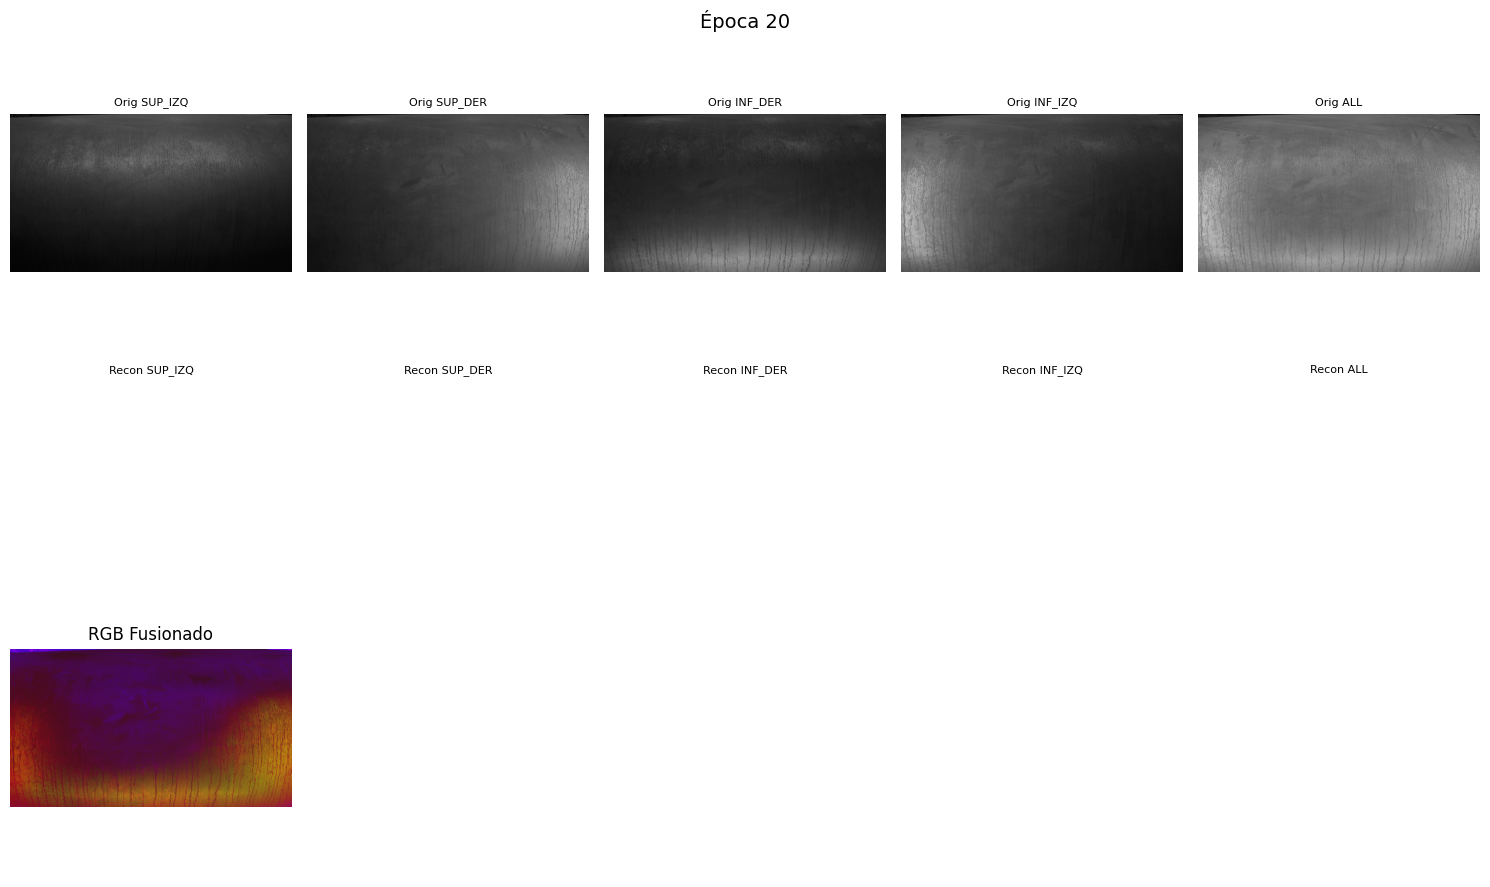

Ep  21/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  22/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  23/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  24/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  25/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Checkpoint guardado: epoch 25


Ep  26/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  27/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  28/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  29/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  30/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


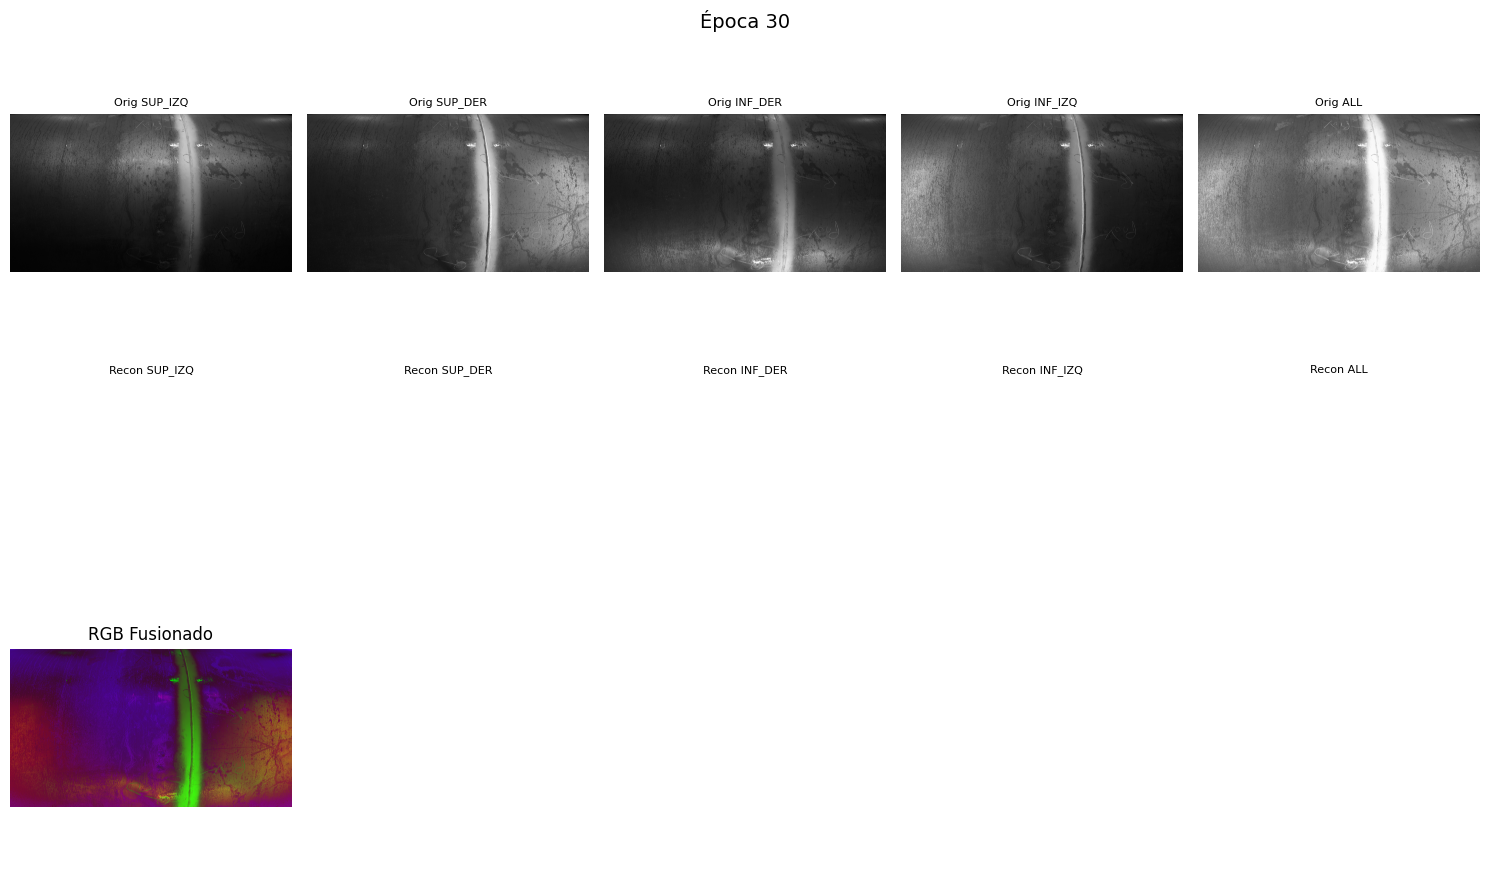

Ep  31/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  32/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  33/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  34/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  35/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  36/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  37/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  38/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  39/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  40/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


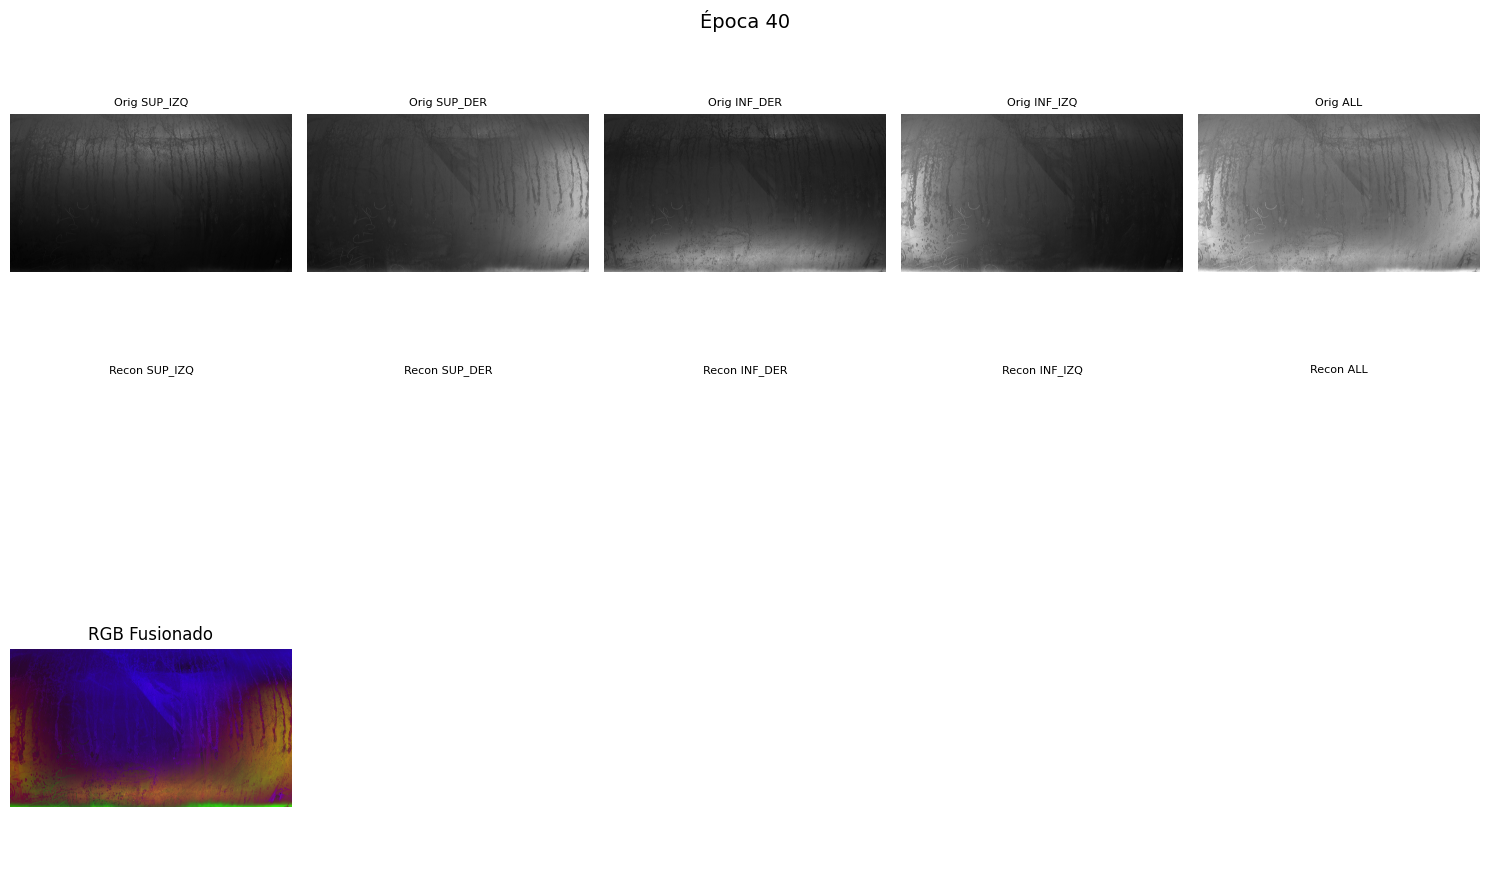

Ep  41/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  42/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  43/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  44/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  45/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  46/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  47/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  48/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  49/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  50/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


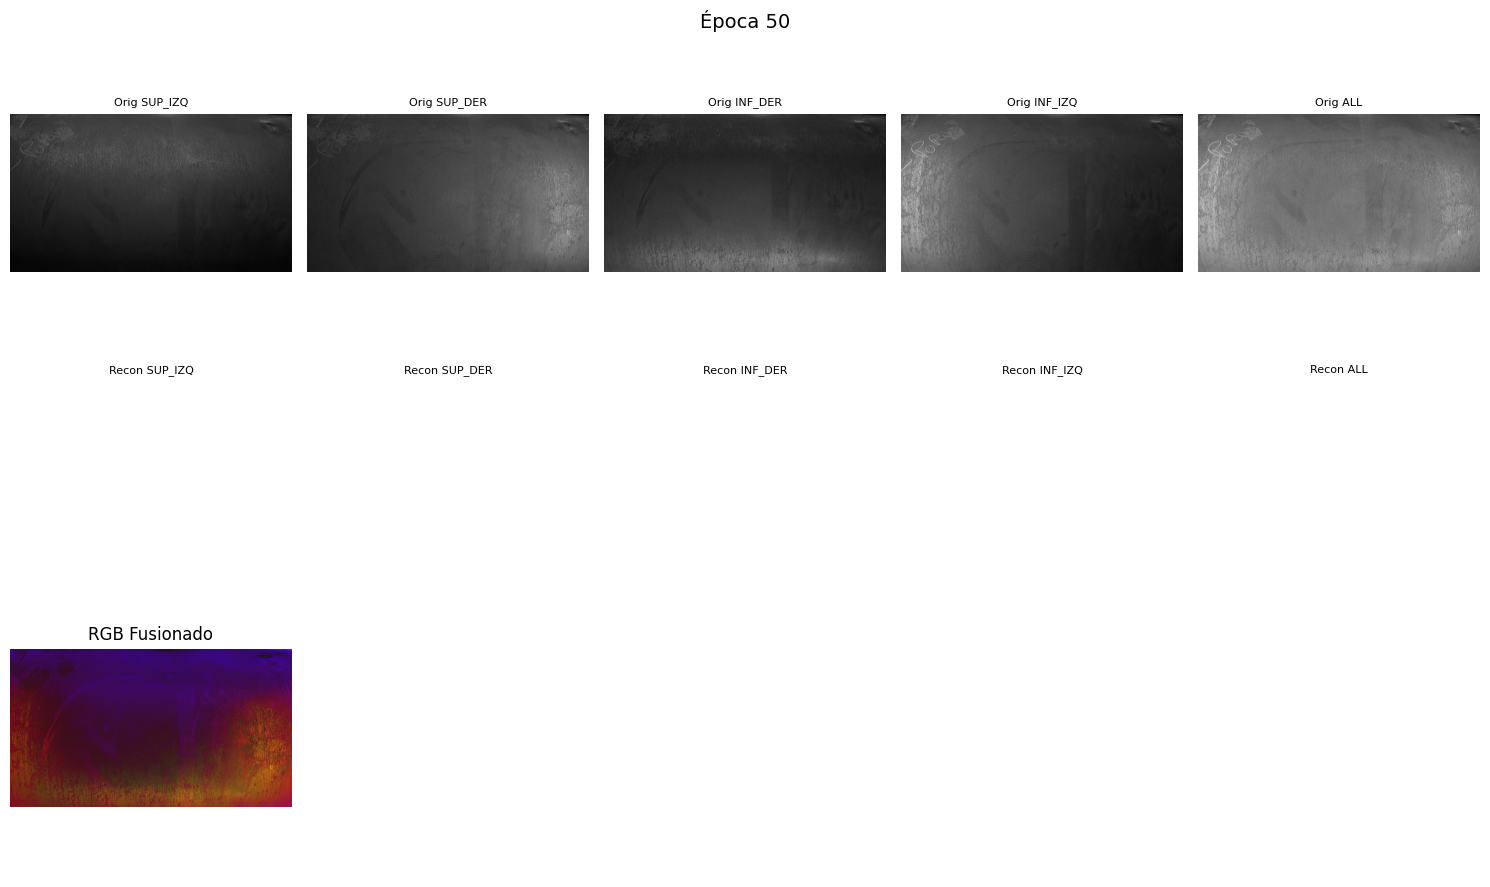

  >> Checkpoint guardado: epoch 50


Ep  51/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  52/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  53/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  54/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  55/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  56/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  57/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  58/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  59/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  60/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


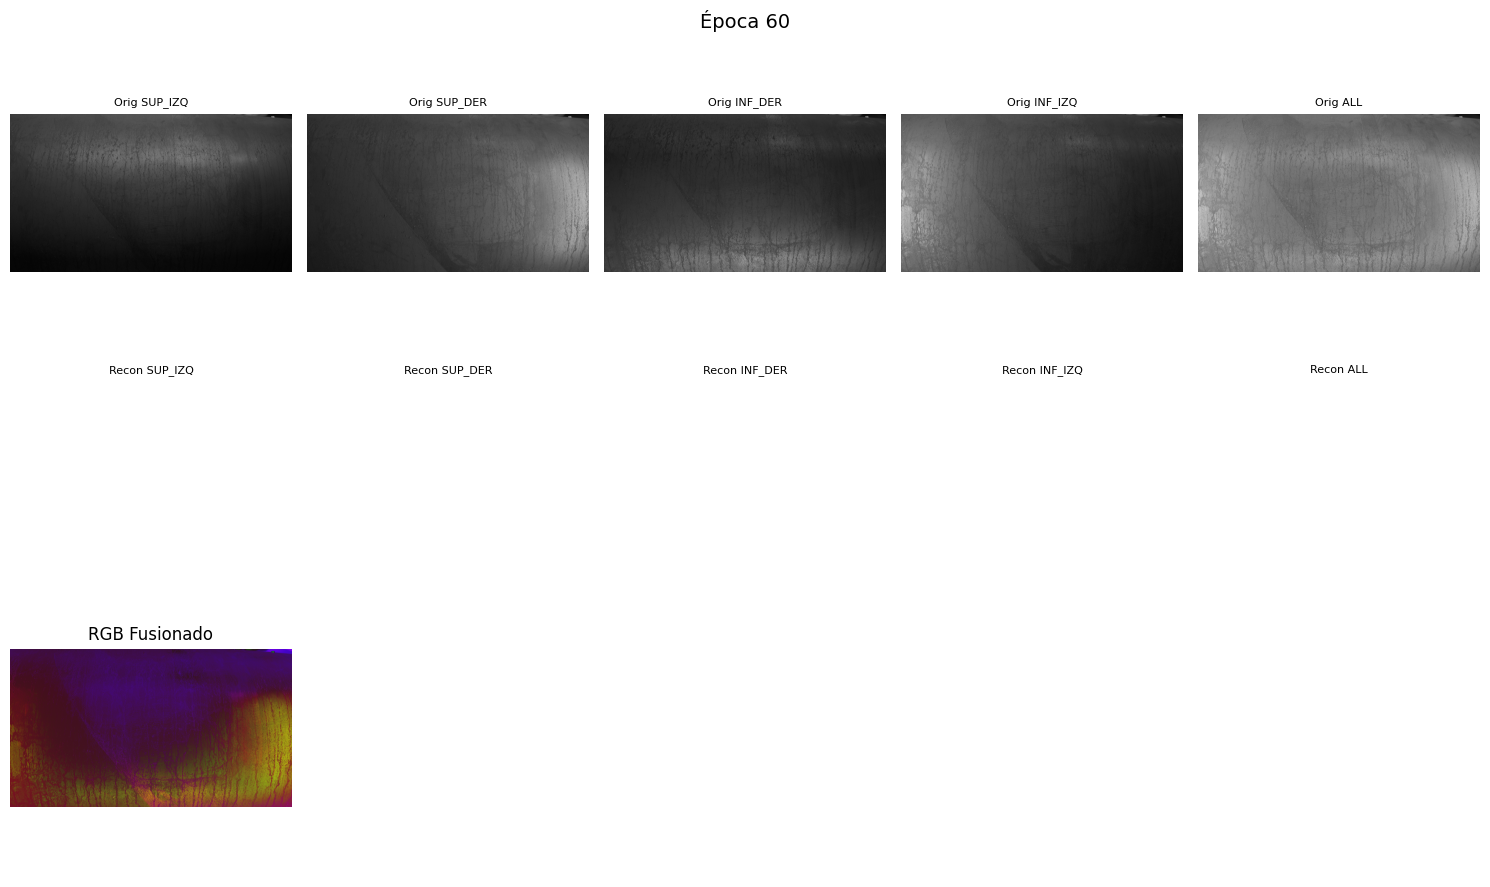

Ep  61/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  62/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  63/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  64/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  65/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  66/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  67/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  68/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  69/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  70/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


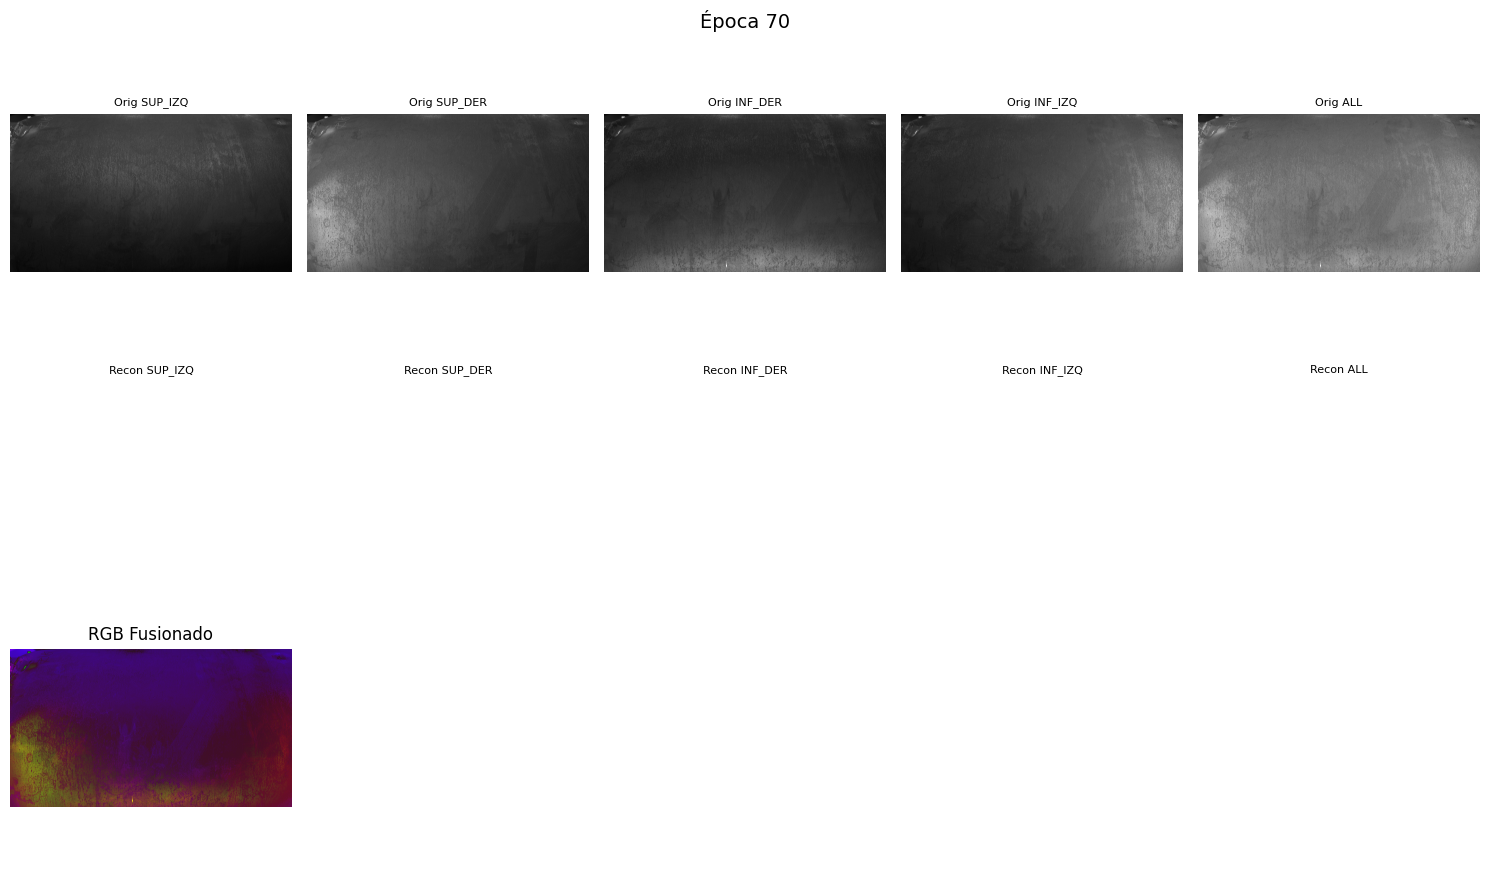

Ep  71/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  72/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  73/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  74/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  75/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Checkpoint guardado: epoch 75


Ep  76/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  77/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  78/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  79/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  80/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


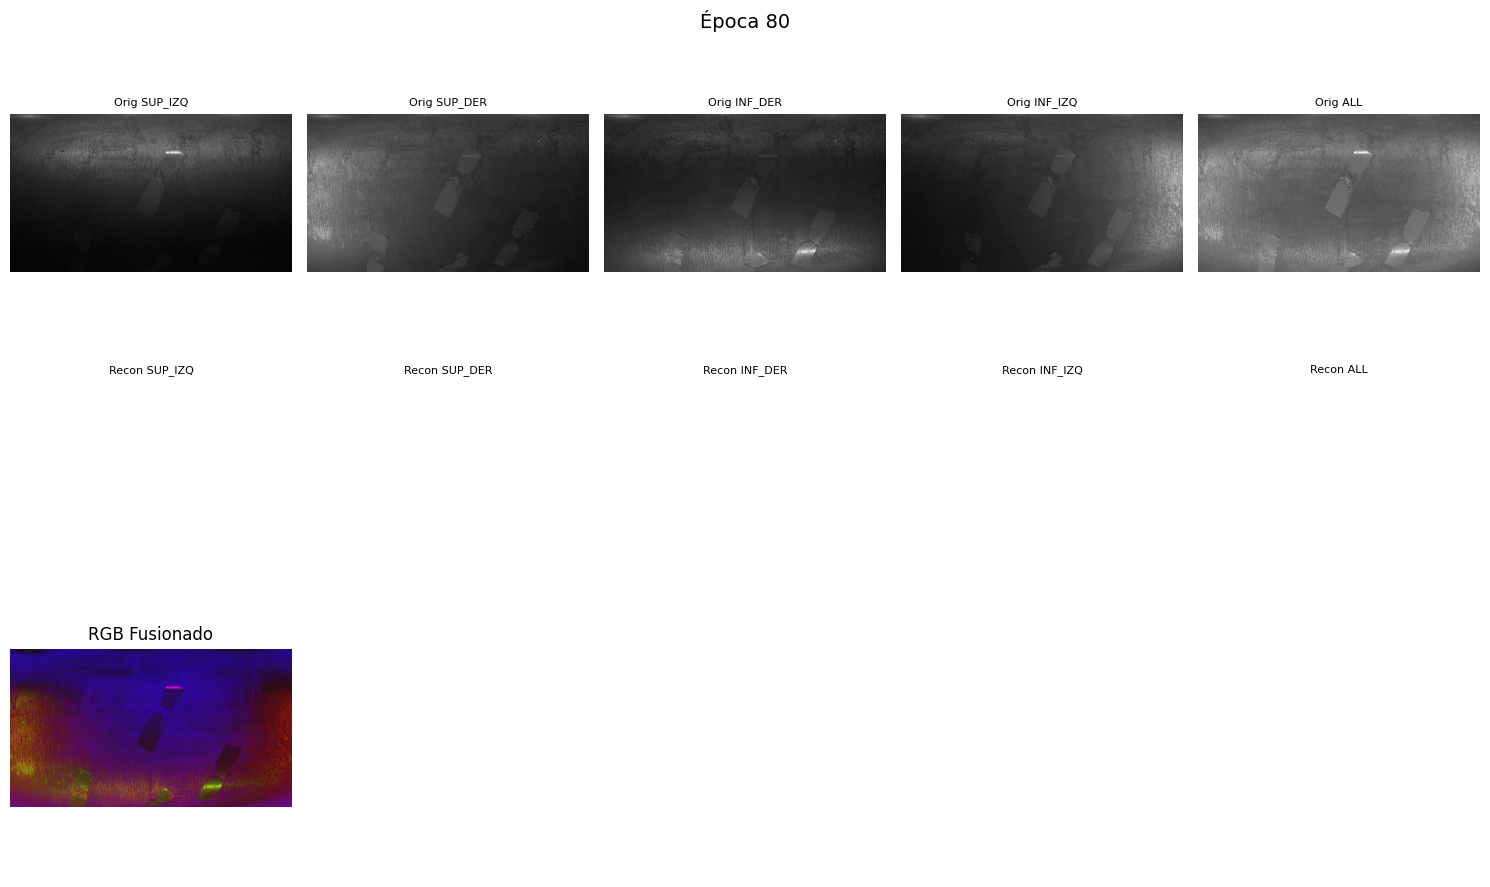

Ep  81/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  82/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  83/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  84/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  85/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  86/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  87/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  88/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  89/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  90/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


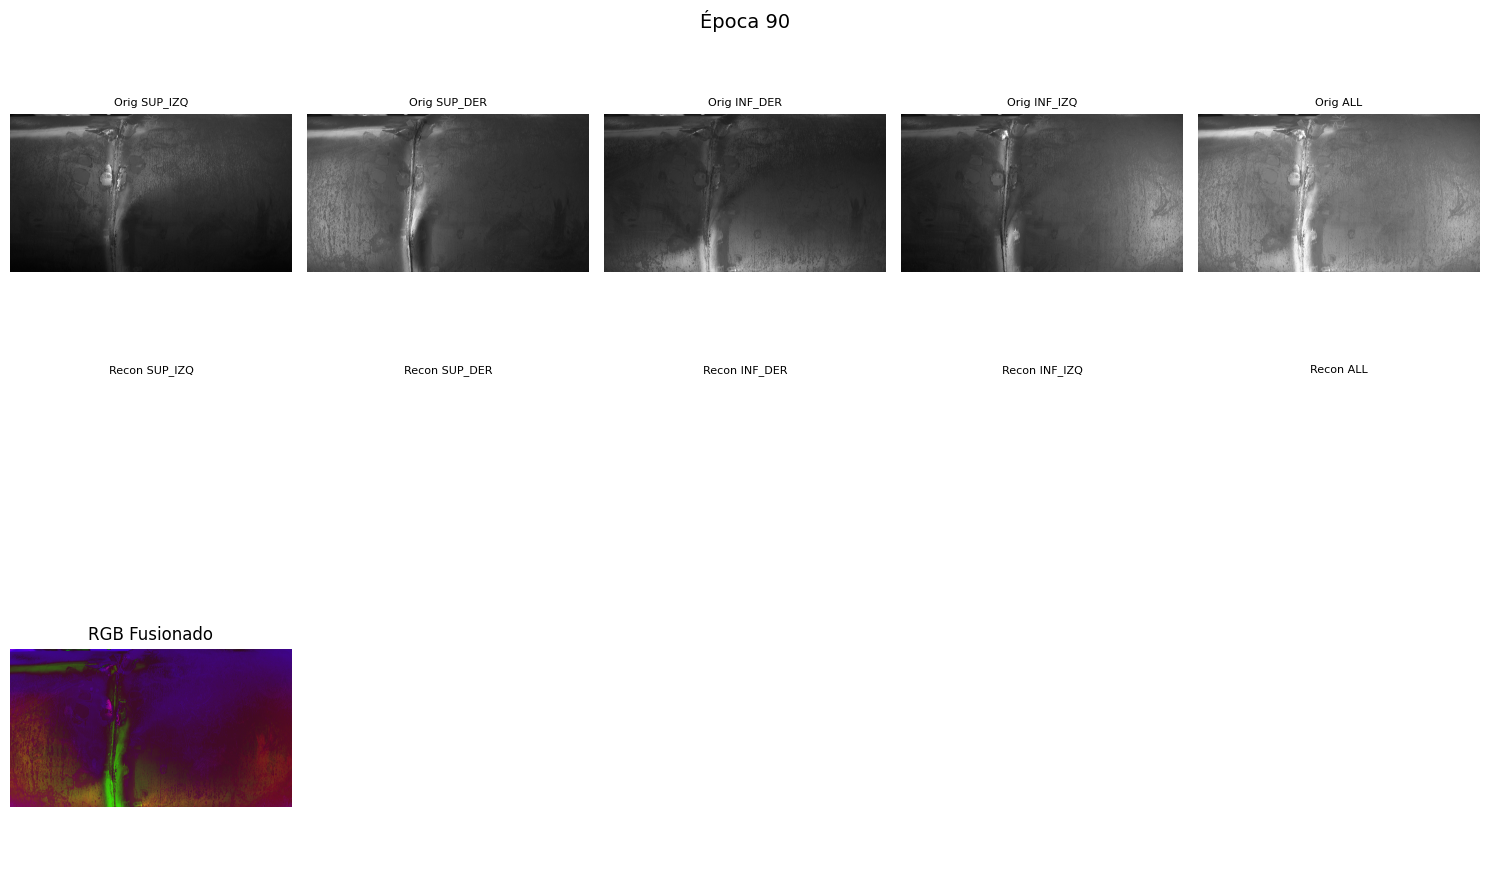

Ep  91/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  92/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  93/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  94/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  95/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  96/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  97/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  98/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep  99/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 100/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


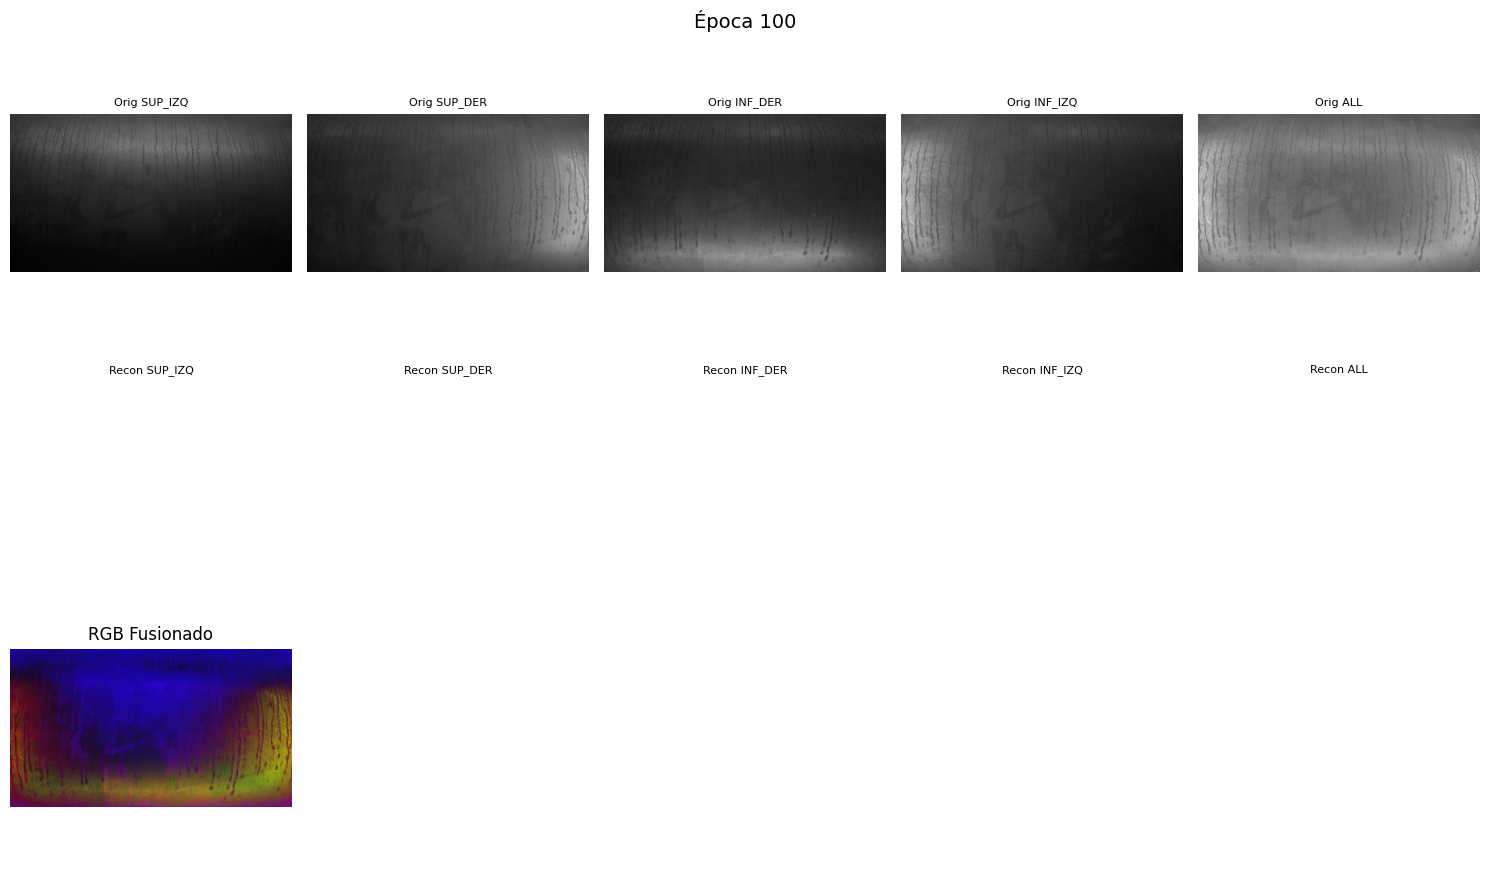

  >> Checkpoint guardado: epoch 100


Ep 101/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 102/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 103/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 104/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 105/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 106/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 107/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 108/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 109/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 110/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


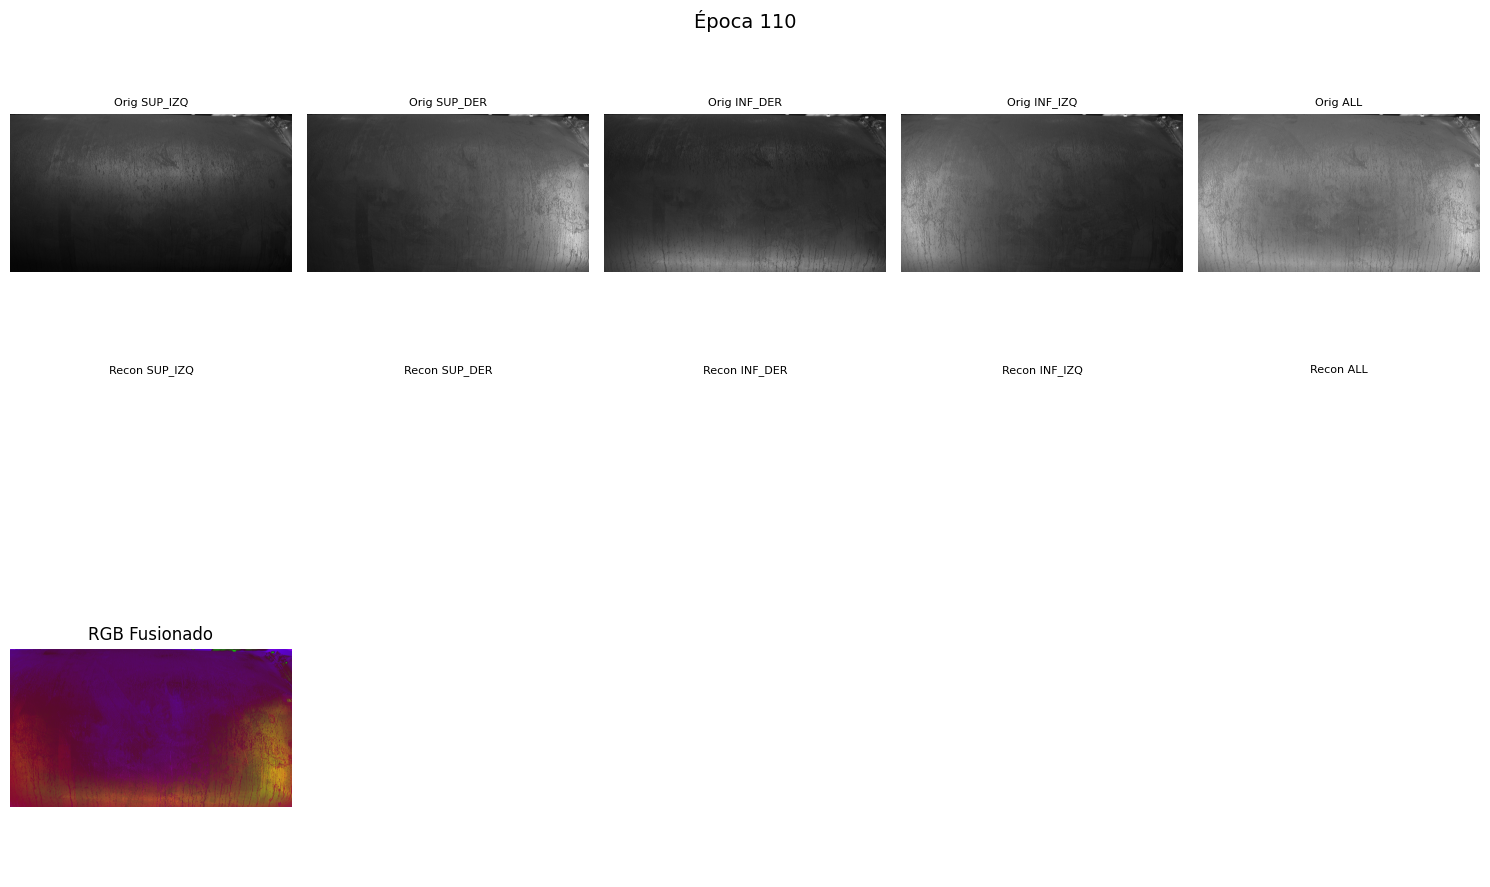

Ep 111/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 112/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 113/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 114/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 115/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 116/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 117/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 118/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 119/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 120/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


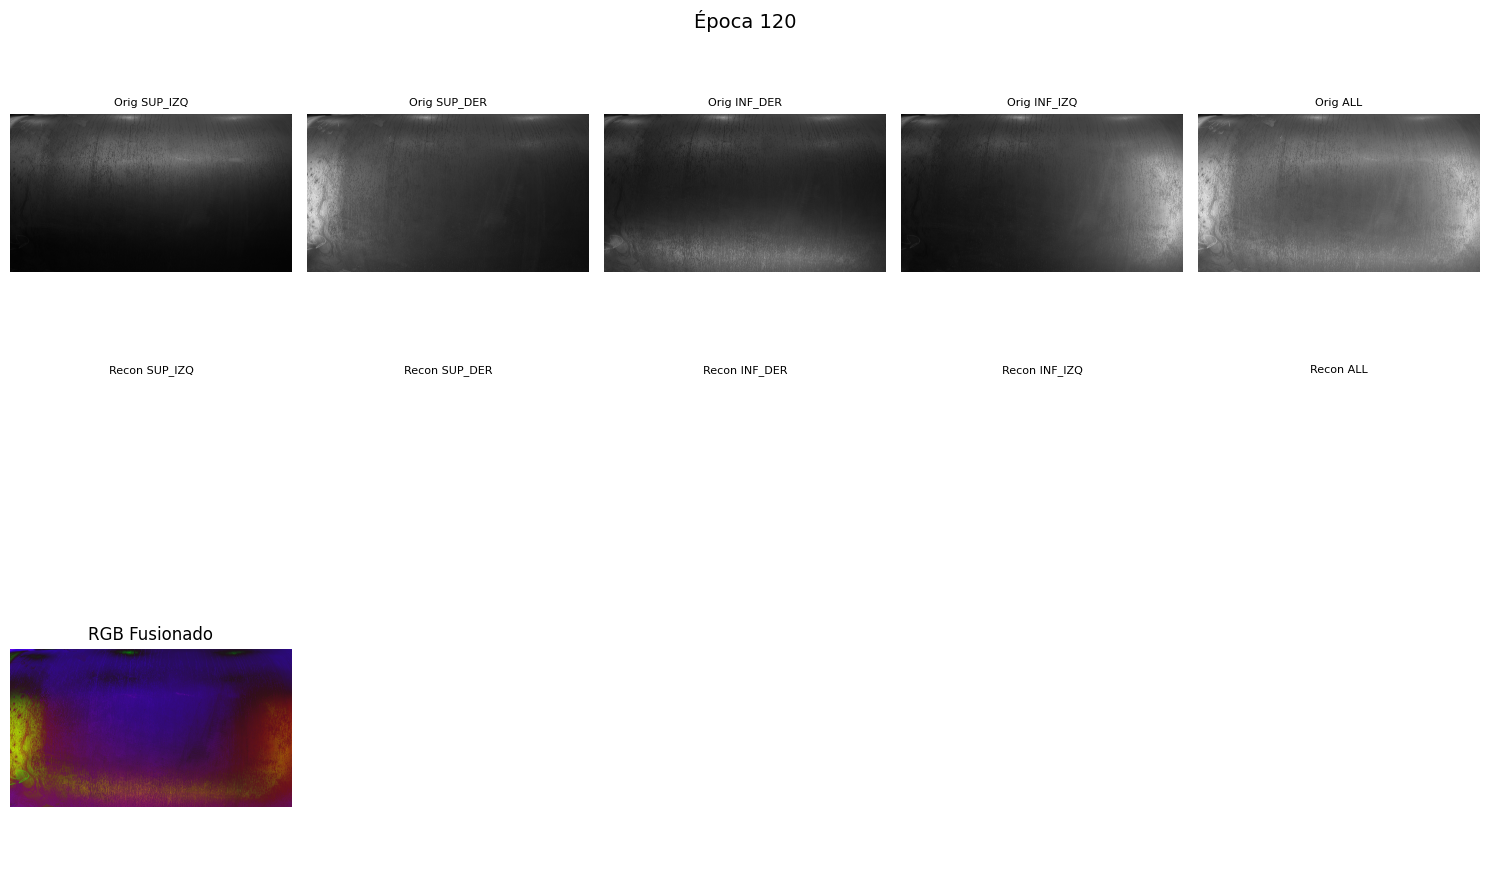

Ep 121/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 122/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 123/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 124/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 125/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Checkpoint guardado: epoch 125


Ep 126/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 127/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 128/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 129/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 130/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


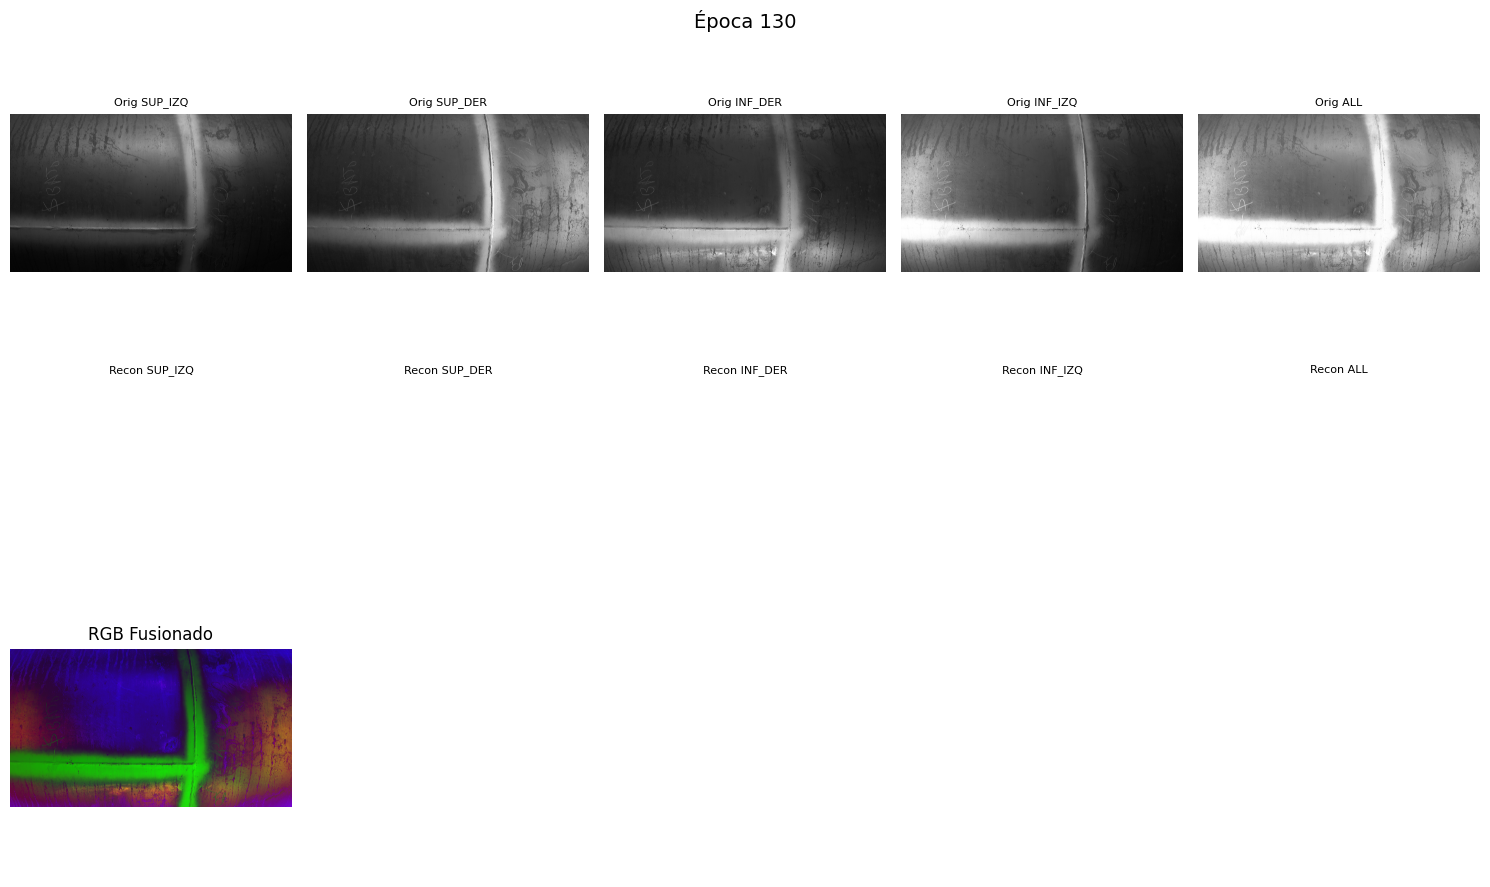

Ep 131/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 132/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 133/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 134/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 135/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 136/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 137/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 138/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 139/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 140/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


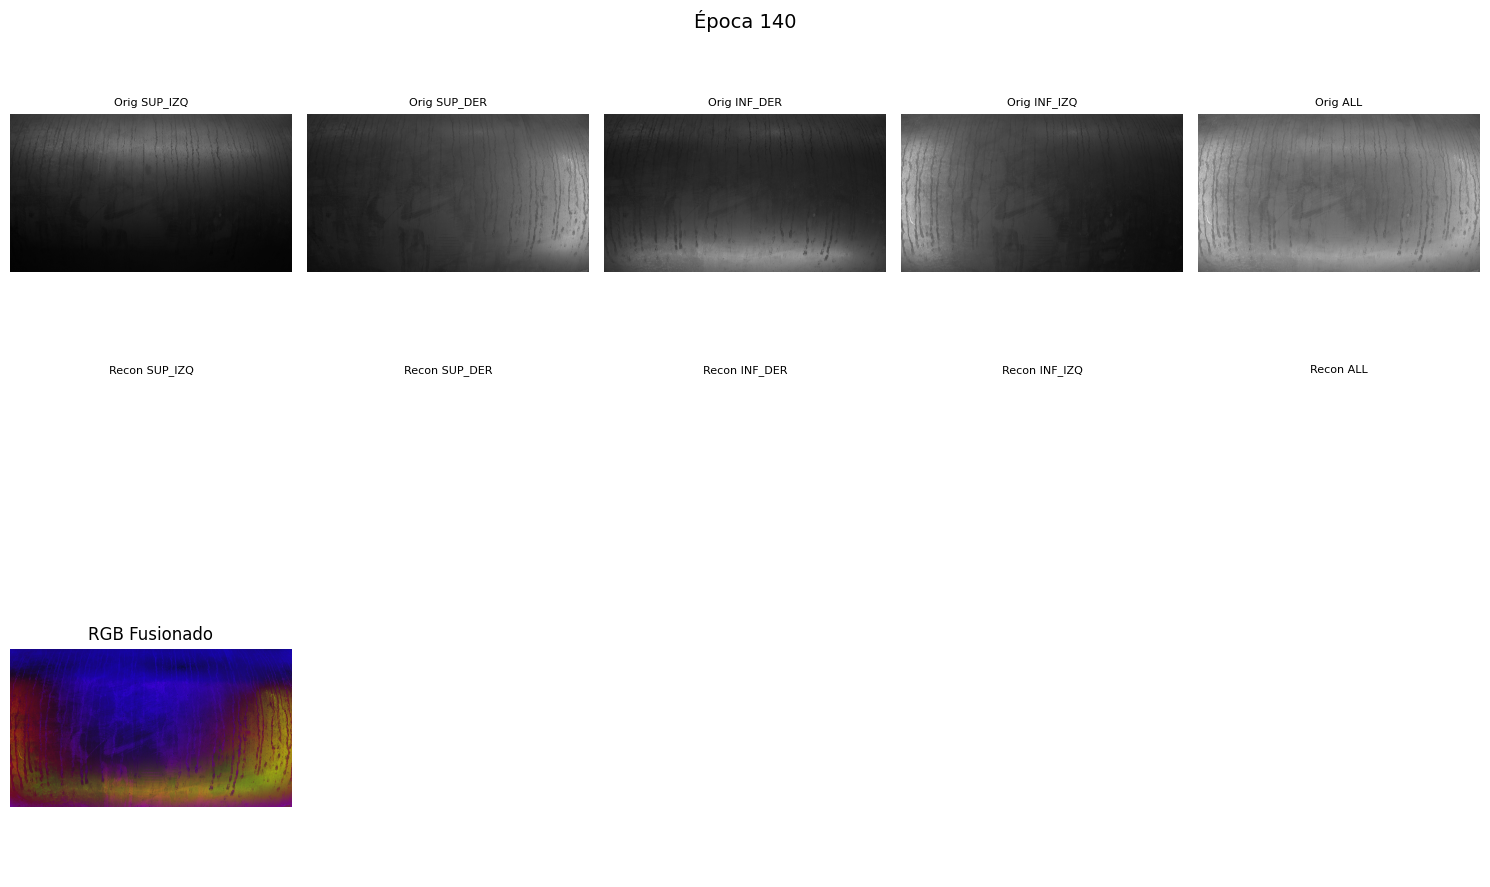

Ep 141/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 142/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 143/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 144/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 145/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 146/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 147/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 148/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 149/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128


Ep 150/150 | Loss: nan (mse:nan ssim:nan vq:inf) | Perp: 1.0/128
  >> Mem: 1.80 GB asignada, 15.49 GB máx
  >> Codebook reset: 127 entradas reemplazadas, utilización: 1%


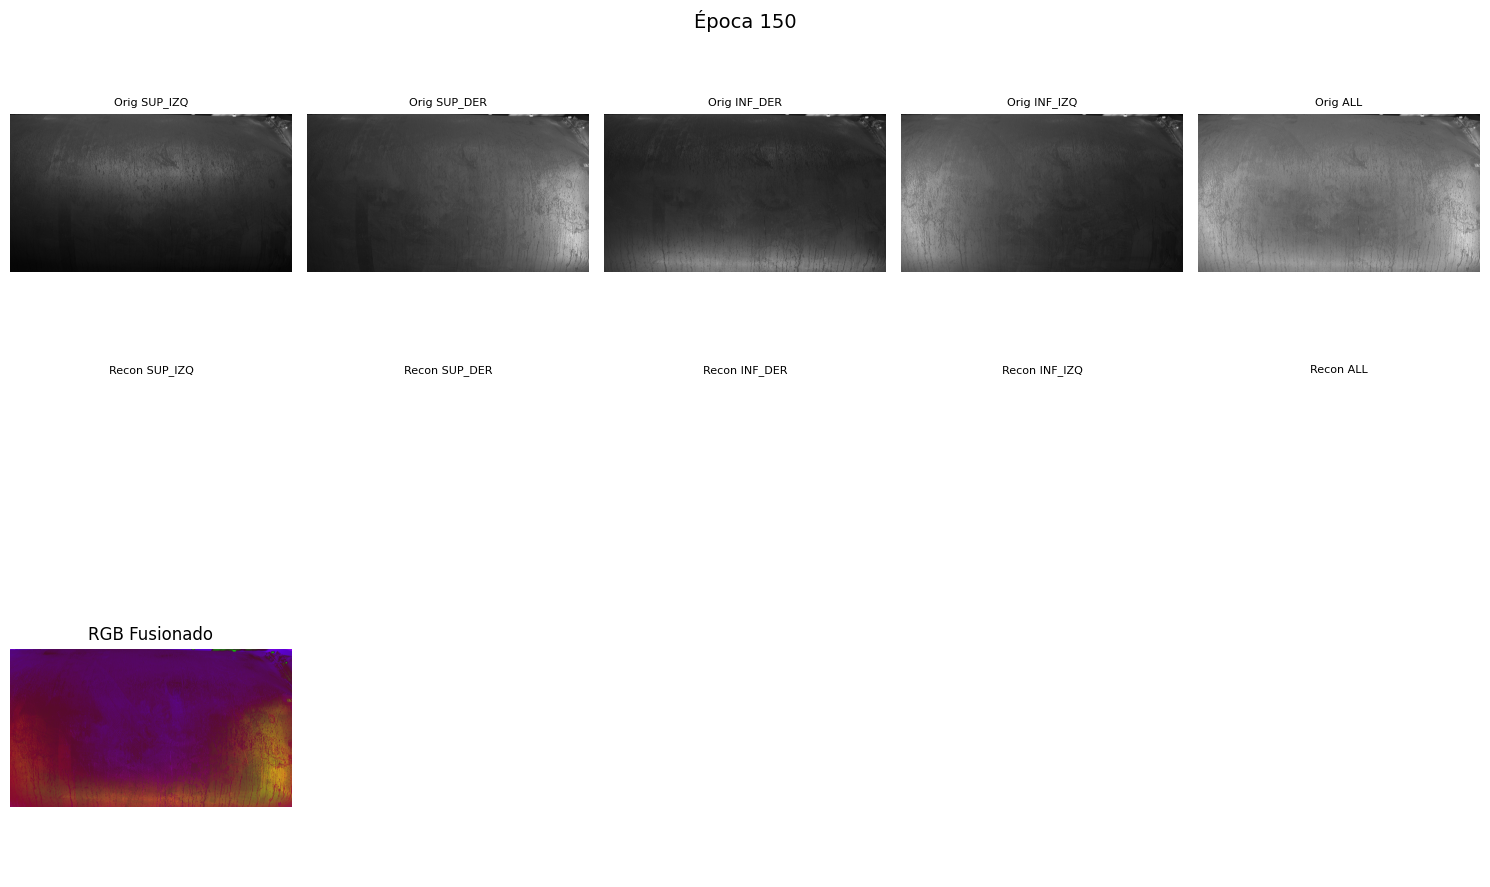

  >> Checkpoint guardado: epoch 150


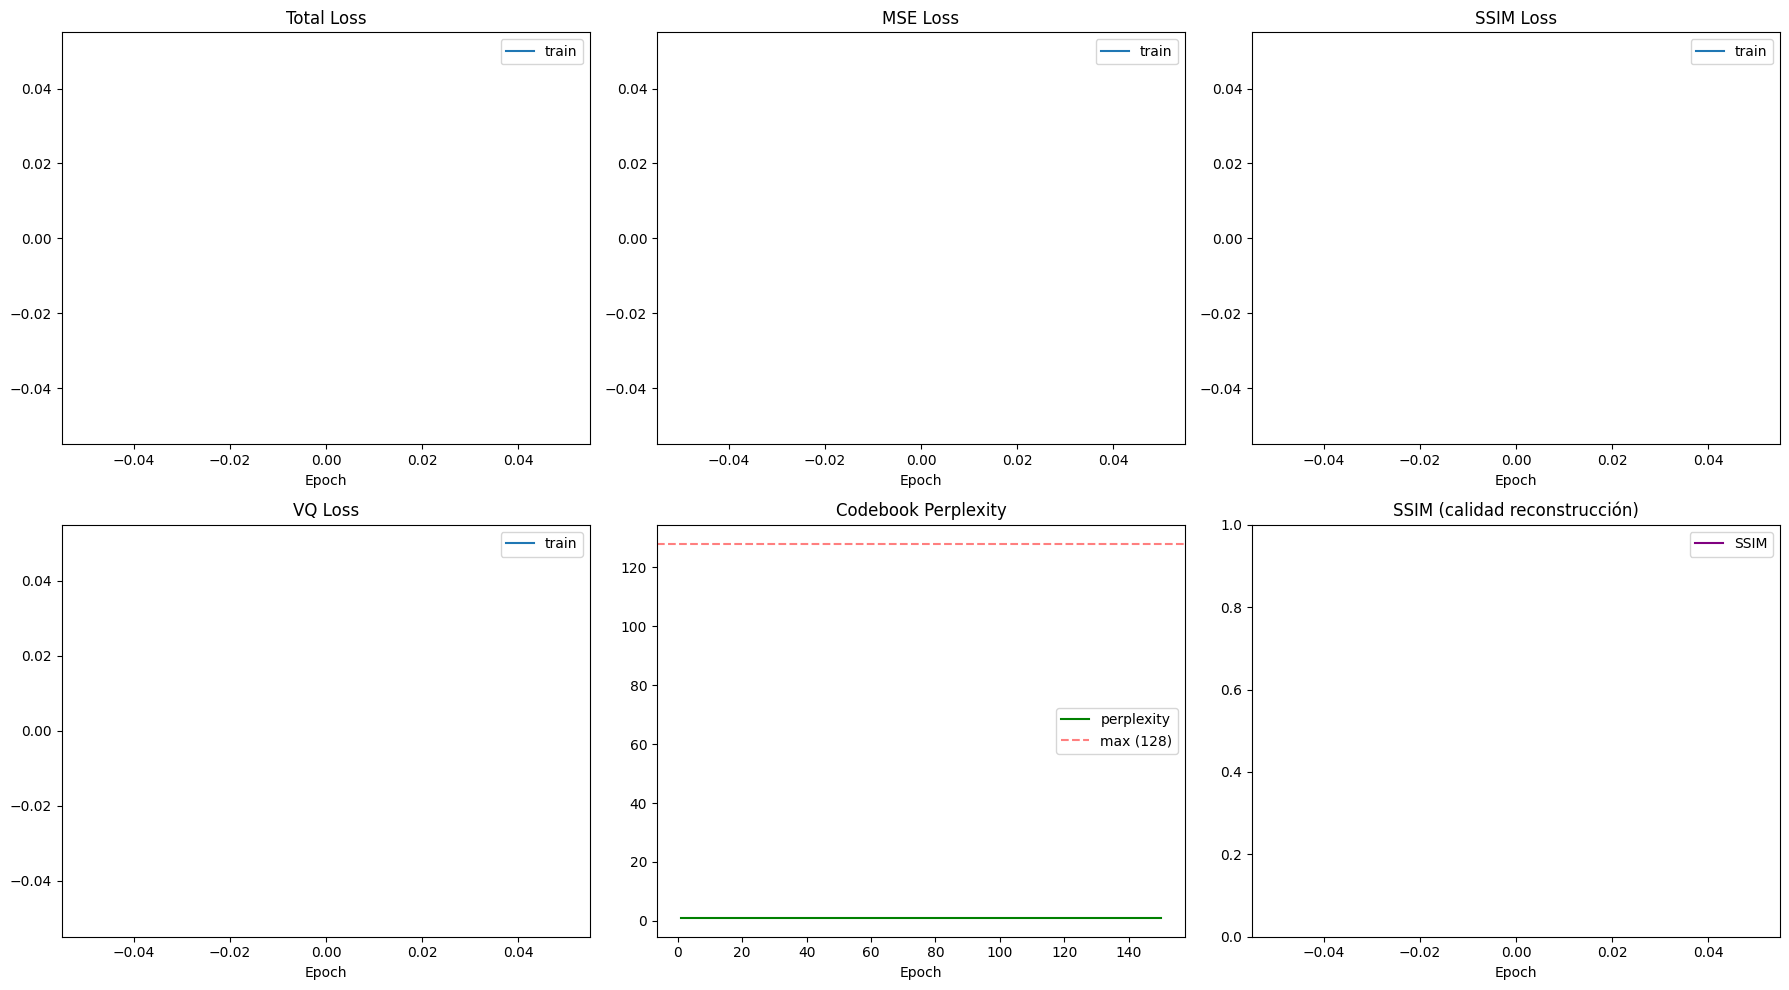


Entrenamiento completado. Loss final: nan
Perplexity final: 1.0/128
Resultados en: runs/ae_tscm_v6_20260127_144946


In [57]:
# ============================================================
# Optimizador y scaler (AMP) — SIN SCHEDULER, LR constante
# ============================================================
optimizer = Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scaler = GradScaler('cuda')

# Historial
history = {k: [] for k in ['total', 'mse', 'ssim', 'vq', 'perplexity']}

print(f'Iniciando entrenamiento: {CONFIG["epochs"]} épocas')
print(f'Muestras: {len(train_dataset)} (todas, sin split)')
print(f'Batch size: {CONFIG["batch_size"]} | Gradient accumulation: {CONFIG["gradient_accumulation_steps"]} (batch efectivo: {CONFIG["batch_size"] * CONFIG["gradient_accumulation_steps"]})')
print(f'Learning rate: {CONFIG["learning_rate"]} (CONSTANTE, sin scheduler)')
print(f'Mixed precision (AMP): activado')
print(f'Codebook: {CONFIG["num_embeddings"]} entradas, EMA decay={CONFIG["ema_decay"]}, reset cada {CONFIG["codebook_reset_interval"]} épocas')
print(f'⚡ Optimización de memoria: pin_memory=False, num_workers=0')
print('=' * 70)

for epoch in range(1, CONFIG['epochs'] + 1):
    # Limpiar caché CUDA al inicio de cada época
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Train
    train_losses, avg_perplexity = run_epoch(model, train_loader, optimizer, CONFIG, scaler=scaler, train=True)

    # Guardar historial
    for k in ['total', 'mse', 'ssim', 'vq']:
        history[k].append(train_losses[k])
    history['perplexity'].append(avg_perplexity)

    # Log
    print(f'Ep {epoch:3d}/{CONFIG["epochs"]} | '
          f'Loss: {train_losses["total"]:.4f} (mse:{train_losses["mse"]:.4f} ssim:{train_losses["ssim"]:.4f} vq:{train_losses["vq"]:.4f}) | '
          f'Perp: {avg_perplexity:.1f}/{CONFIG["num_embeddings"]}')
    
    # Mostrar memoria cada 10 épocas
    if epoch % 10 == 0 and torch.cuda.is_available():
        print(f'  >> Mem: {torch.cuda.memory_allocated(0)/1e9:.2f} GB asignada, '
              f'{torch.cuda.max_memory_allocated(0)/1e9:.2f} GB máx')

    # Codebook reset — reemplaza entradas no usadas con outputs reales del encoder
    if epoch % CONFIG['codebook_reset_interval'] == 0:
        z_samples = collect_encoder_outputs(model, train_loader, max_samples=8)
        num_reset = model.vqvae.vq.reset_unused_codes(
            z_samples, threshold=CONFIG['codebook_usage_threshold'])
        usage_pct = (CONFIG['num_embeddings'] - num_reset) / CONFIG['num_embeddings'] * 100
        print(f'  >> Codebook reset: {num_reset} entradas reemplazadas, '
              f'utilización: {usage_pct:.0f}%')

    # Visualización
    if epoch % CONFIG['log_interval'] == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            sample = next(iter(train_loader)).to(device)
            with autocast('cuda'):
                recon, _, _, rgb, _, _ = model(sample, return_intermediate=True)
            save_visualization(sample, recon.float(), rgb.float(), epoch,
                               os.path.join(SAVE_DIR, 'visualizations'))

    # Checkpoint
    if epoch % CONFIG['save_interval'] == 0:
        ckpt_path = os.path.join(SAVE_DIR, 'checkpoints', f'ckpt_epoch_{epoch:04d}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'train_loss': train_losses['total'],
            'perplexity': avg_perplexity,
            'config': CONFIG
        }, ckpt_path)
        print(f'  >> Checkpoint guardado: epoch {epoch}')

# Guardar modelo final y gráficas
torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'final_model.pt'))
plot_losses(history, SAVE_DIR)

print('\n' + '=' * 70)
print(f'Entrenamiento completado. Loss final: {train_losses["total"]:.4f}')
print(f'Perplexity final: {avg_perplexity:.1f}/{CONFIG["num_embeddings"]}')
print(f'Resultados en: {SAVE_DIR}')

## 8. Evaluación final

In [ ]:
# Cargar modelo final y visualizar reconstrucciones
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'final_model.pt')))
model.eval()

print('Visualización de muestras con el modelo final:\n')

# Métricas finales agregadas
all_mse = []
all_ssim = []

with torch.no_grad():
    for i, batch in enumerate(train_loader):
        batch = batch.to(device)
        with autocast('cuda'):
            recon, vq_loss, perp, rgb, ch_att, sp_att = model(batch, return_intermediate=True)

        # Métricas por muestra
        mse_val = F.mse_loss(recon.float(), batch).item()
        ssim_val = ssim(recon.float(), batch, data_range=1.0, size_average=True).item()
        all_mse.append(mse_val)
        all_ssim.append(ssim_val)

        if i < 3:  # Solo mostrar 3 muestras detalladas
            # Channel attention weights
            ch_weights = ch_att.float().cpu().numpy().flatten()
            print(f'Muestra {i} — MSE: {mse_val:.4f}, SSIM: {ssim_val:.4f}')
            print(f'  Channel Attention weights:')
            for j, name in enumerate(LIGHT_NAMES):
                bar = '█' * int(ch_weights[j] * 30)
                print(f'    {name:8s}: {ch_weights[j]:.3f} {bar}')
            print()

            # Visualizar
            orig = batch[0].cpu()
            rec = recon[0].float().cpu()

            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            for j in range(5):
                axes[0, j].imshow(orig[j], cmap='gray', vmin=0, vmax=1)
                axes[0, j].set_title(f'Orig {LIGHT_NAMES[j]}', fontsize=9)
                axes[0, j].axis('off')
                axes[1, j].imshow(rec[j], cmap='gray', vmin=0, vmax=1)
                axes[1, j].set_title(f'Recon {LIGHT_NAMES[j]}', fontsize=9)
                axes[1, j].axis('off')
            plt.suptitle(f'Muestra {i} — MSE: {mse_val:.4f}, SSIM: {ssim_val:.4f}')
            plt.tight_layout()
            plt.show()

# Resumen
print('=' * 50)
print(f'Métricas finales sobre {len(all_mse)} muestras:')
print(f'  MSE  medio: {sum(all_mse)/len(all_mse):.4f}')
print(f'  SSIM medio: {sum(all_ssim)/len(all_ssim):.4f}')
print(f'  Perplexity final: {history["perplexity"][-1]:.1f}/{CONFIG["num_embeddings"]}')

In [ ]:
# Mostrar spatial attention del modelo final
with torch.no_grad():
    sample = next(iter(train_loader)).to(device)
    with autocast('cuda'):
        _, _, _, rgb, _, sp_att = model(sample, return_intermediate=True)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Spatial attention map
    sp_map = sp_att[0, 0].float().cpu().numpy()
    axes[0].imshow(sp_map, cmap='hot')
    axes[0].set_title('Spatial Attention (zonas importantes)')
    axes[0].axis('off')

    # RGB fusionado
    rgb_np = rgb[0].float().cpu().permute(1, 2, 0).numpy()
    rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min() + 1e-8)
    axes[1].imshow(rgb_np)
    axes[1].set_title('RGB Fusionado')
    axes[1].axis('off')

    # Original SUP_IZQ como referencia
    axes[2].imshow(sample[0, 0].cpu(), cmap='gray')
    axes[2].set_title(f'Original {LIGHT_NAMES[0]}')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'attention_analysis.png'), dpi=150)
    plt.show()